In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist
import torch.nn.functional as F
from IPython import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

im_path = '../images'

In [38]:
device

device(type='cuda', index=0)

In [4]:
data = pd.read_csv('var_10.csv').drop('Unnamed: 0', axis = 1)

In [3]:
data.columns

Index(['ID', 'NAME', 'r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y',
       'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y', 'l knee_X', 'l knee_Y',
       'l ankle_X', 'l ankle_Y', 'pelvis_X', 'pelvis_Y', 'thorax_X',
       'thorax_Y', 'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y',
       'r wrist_X', 'r wrist_Y', 'r elbow_X', 'r elbow_Y', 'r shoulder_X',
       'r shoulder_Y', 'l shoulder_X', 'l shoulder_Y', 'l elbow_X',
       'l elbow_Y', 'l wrist_X', 'l wrist_Y', 'Scale', 'Activity', 'Category'],
      dtype='object')

In [5]:
def draw(points, image, ax):
    # fig, ax = plt.subplots()
    
    ax.imshow(image)

    keypoints_x = points[::2]
    keypoints_y = points[1::2]

    for i in range(len(keypoints_x)):
        ax.scatter(keypoints_x[i], keypoints_y[i], color='red', marker='o')

    ax.plot(keypoints_x[:3],keypoints_y[:3],color='blue')
    ax.plot(keypoints_x[3:6],keypoints_y[3:6],color='blue')
    ax.plot(keypoints_x[-6:-3],keypoints_y[-6:-3],color='blue')
    ax.plot(keypoints_x[-3:],keypoints_y[-3:],color='blue')
    ax.plot(keypoints_x[6:10],keypoints_y[6:10],color='blue')
    
    ax.plot([keypoints_x[-4]]+[keypoints_x[7]]+[keypoints_x[-3]],[keypoints_y[-4]]+[keypoints_y[7]]+[keypoints_y[-3]],color='blue')
    ax.plot([keypoints_x[2]]+[keypoints_x[6]]+[keypoints_x[3]],[keypoints_y[2]]+[keypoints_y[6]]+[keypoints_y[3]],color='blue')
       
    # print(keypoints_x[-4]+keypoints_x[7]+keypoints_x[-3])

    ax.axis('off')

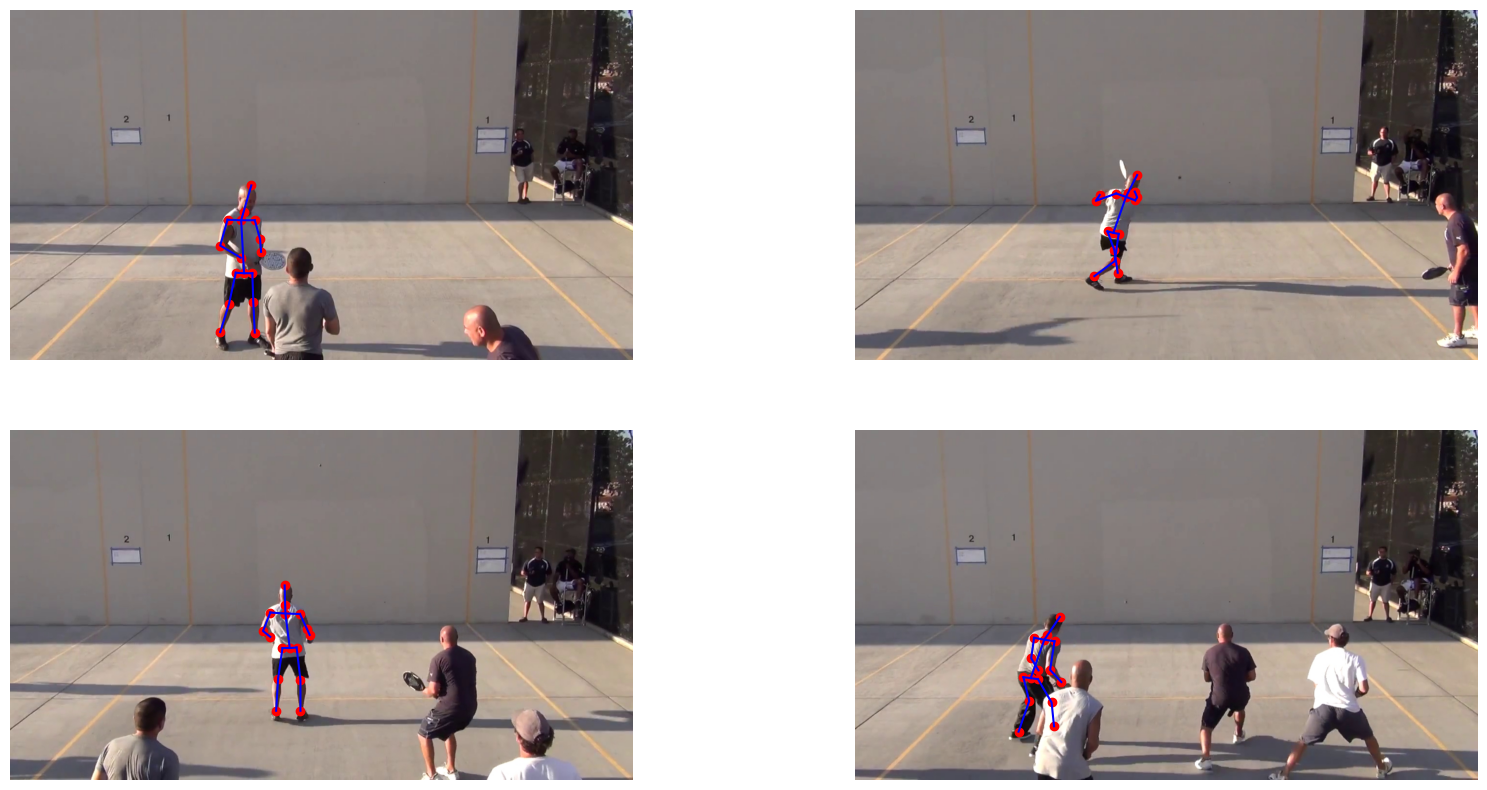

In [4]:
fig, axs = plt.subplots(2,2, figsize =(20,10))
ctr = 0
for _, row in data.iterrows():
    if ctr > 3:
        break
    name = row.values[1]
    ctr+=1
    # print(row.values[2:34])
    pts = row.values[2:34]
    im = Image.open(im_path+'/'+name)
    # plt.imshow(im)
    draw(pts, im, axs[(ctr-1)//2][(ctr-1)%2])
plt.show()

In [6]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
im_transform = transforms.Compose([
    # transforms.Resize(size = (260,260)),
    # transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

same_transform = transforms.Compose([
    transforms.Resize(size = (260,260)),
    transforms.ToTensor()
])

res_transform = transforms.Compose([
    transforms.Resize(size = (256,256)),
    transforms.ToTensor()
])

to_tens = transforms.Compose([
    transforms.ToTensor()
])

to_im = transforms.Compose([
    transforms.ToPILImage()
])

In [7]:
input = []
output = []
orig_lens = []
ctr = 0
for _, row in data.iterrows():
    print(ctr)
    ctr+=1
    name = row.values[1]
    pts = row.values[2:34]
    im = Image.open(im_path+'/'+name)
    orig_lens.append(im.size)
    for i in range(len(pts)//2):
        pts[2*i] = pts[2*i]*260//im.size[0]
        pts[2*i+1] = pts[2*i+1]*260//im.size[1]
    input.append(res_transform(im))
    output.append(pts)
input = torch.stack(input, dim = 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
xx_train, xx_test, yy_train, yy_test = train_test_split(input, output, test_size=0.2, random_state=42)

In [9]:
ttrain_dataset = torch.utils.data.TensorDataset(torch.Tensor(xx_train).float(),torch.Tensor(yy_train).float())
ttest_dataset = torch.utils.data.TensorDataset(torch.Tensor(xx_test).float(), torch.Tensor(yy_test).float())

ttrain_dataloader = torch.utils.data.DataLoader(ttrain_dataset, batch_size=16, shuffle=True)
ttest_dataloader = torch.utils.data.DataLoader(ttest_dataset, batch_size=16, shuffle=False)

C:\Users\k_dys\AppData\Local\Temp\ipykernel_9968\3942604350.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  ttrain_dataset = torch.utils.data.TensorDataset(torch.Tensor(xx_train).float(),torch.Tensor(yy_train).float())


In [15]:

tttest_dataset = torch.utils.data.TensorDataset(torch.Tensor(xx_test).float(), torch.Tensor(yy_test).float())

tttest_dataloader = torch.utils.data.DataLoader(ttest_dataset, batch_size=16, shuffle=True)

In [18]:
def make_net(net, optimizer, n_epoch, criterion, device):

    loss_history = []
    
    train_loss = []
    
    val_loss = []

    for i in range(n_epoch):
        epoch_loss = 0
        for x_batch, y_batch in ttrain_dataloader:

            # Forward
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            predictions = net(x_batch)
            loss = criterion(predictions, y_batch)
            epoch_loss+=loss.item()*x_batch.shape[0]
            # Backward
            loss.backward()
            
            # Update weights
            optimizer.step()
            optimizer.zero_grad()

            loss_history.append(loss.item())
            
        train_loss.append(epoch_loss/631)
        epoch_loss = 0
        
        
        for x_batch, y_batch in ttest_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = net(x_batch)
            loss = criterion(predictions, y_batch)
            epoch_loss+=loss.item()*x_batch.shape[0]
        val_loss.append(epoch_loss/158)
        
        
        # Visualize
        display.clear_output(wait=True)
        fig, axs = plt.subplots(1,2,figsize = (14,7))
        axs[0].plot(loss_history)
        axs[1].plot(train_loss, color = 'red')
        axs[1].plot(val_loss, color = 'green')

        plt.show()

        print('Current loss: %f' % loss)
    
    net.to(device)  
    return net

In [12]:
from torchvision.models import resnet50
class KeypointModel(nn.Module):
    def __init__(self, pretrained=False, requires_grad=True):
        super(KeypointModel, self).__init__()
        if pretrained:
            self.model = resnet50(weights='DEFAULT')
        else:
            self.model = resnet50(weights=None)
        if requires_grad:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        else:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.model.fc = nn.Linear(in_features=2048, out_features=32)
    def forward(self, x):
        out = self.model(x)
        return out

In [13]:
net = KeypointModel(pretrained=True, requires_grad=True)

Training intermediate layer parameters...


In [42]:
net = nn.Sequential(
nn.Linear(34, 32),
)

In [15]:
n_epoch = 50
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()

In [37]:
device = 'cuda'
net.to(device)

KeypointModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
net()

Одно микроскопическое НО это 4-го запуска по 50 эпох. Учить 200 эпох ещё раз это выше моих сил.


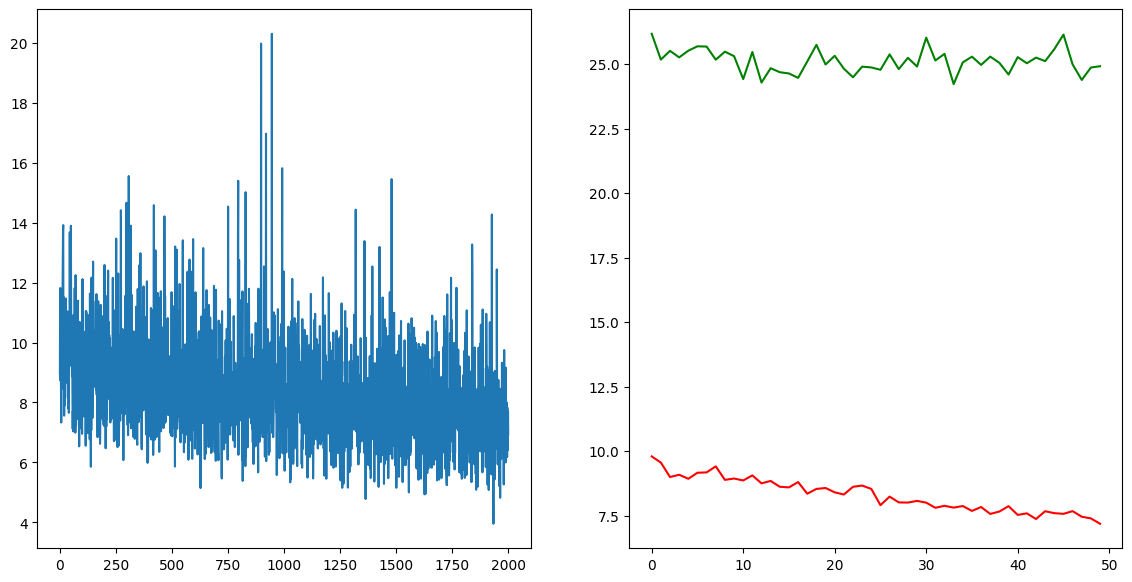

Current loss: 26.952150


In [38]:
net = make_net(net, optimizer, n_epoch, criterion, device)

In [20]:
tr = transforms.ToPILImage()

Там внизу небольшая опечаточка, там все из test-a

In [26]:
def show_people(net, test_dataloader, train_dataloader):
    fig, axs = plt.subplots(2,2,figsize = (20,10))
    axs[0][0].set_title('train')
    net.to('cpu')  
    for x_batch, y_batch in test_dataloader:
        # print(x_batch)
        inp = []
        # for i in range(4):
        #     # temp = rcnn_net([im_transform(x_batch[i])])[0]['keypoints'][0]
        #     print(temp)
        #     inp.append([])
        #     for j in temp:
        #         inp[i].append(float(j[0]))
        #         inp[i].append(float(j[1]))
        # predictions = net(torch.Tensor(inp).float())
        predictions = net(x_batch)
        tmp = predictions
        for j in range(4):
            draw(tmp[j].detach().numpy(), tr(x_batch[j]), axs[j//2][j%2]) 
        
        break
        
    return

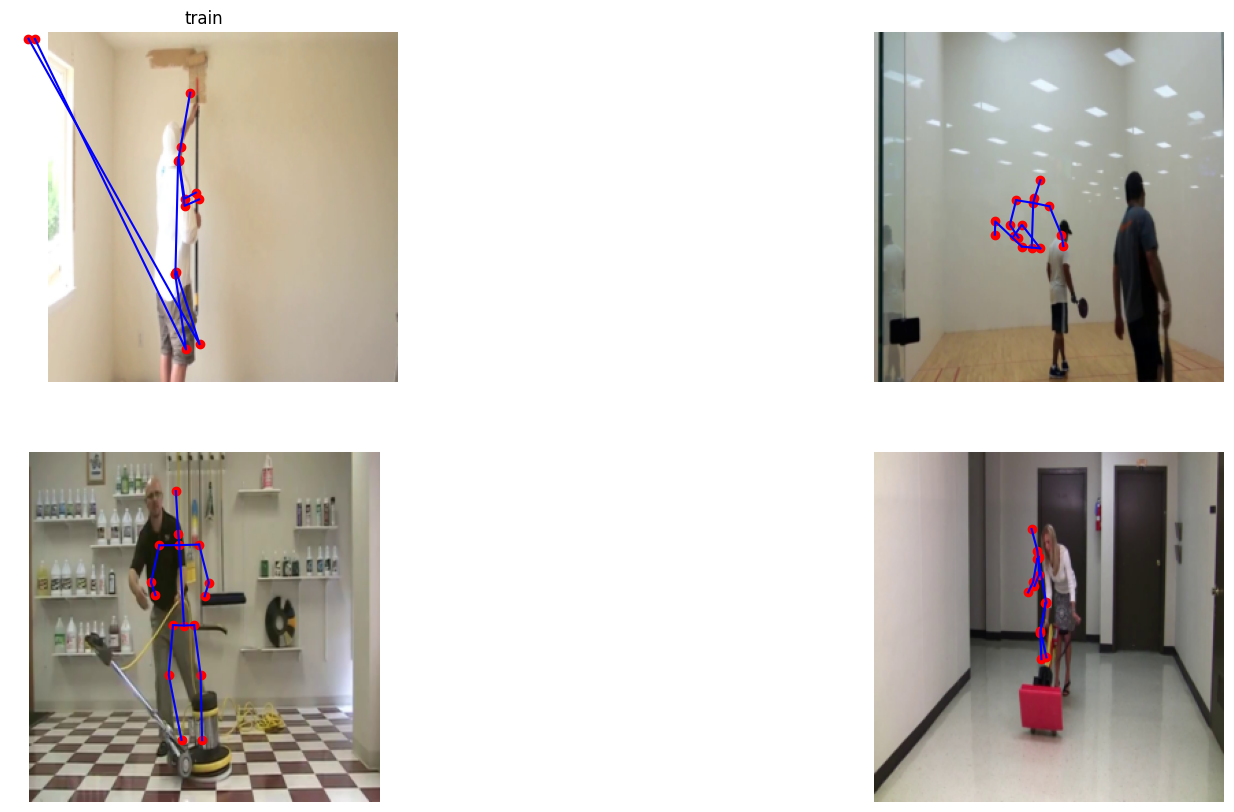

In [39]:
show_people(net, ttest_dataloader, ttrain_dataloader)